# Generating synthetic data sets of a river bed column forced by monoperiodic river and aquifer temperature signals

2024 developped by the student group from ``demo_genData.ipynb`` created by Nicolas Flipo during MOLONARI 2024 and ``demo_Pyheatmy.ipynb``.

The object of this demo is to test the validity of our MCMC inversion.

In order to do so, we first generate a virtual point and its data thanks to ``demo_genData.ipynb`` and then inverse those data to find the parameters of the point. We can then see if we find back the parameters we used to generate the virtual point. 

In [75]:
from pyheatmy import *
import pandas as pd

NBITER = 10

## Génération et traitement d'un jeu de données virtuelles

On exécute le notebook ``demo_genData.ipynb`` pour générer un jeu de données dont on connaîtra les caractéristiques.

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


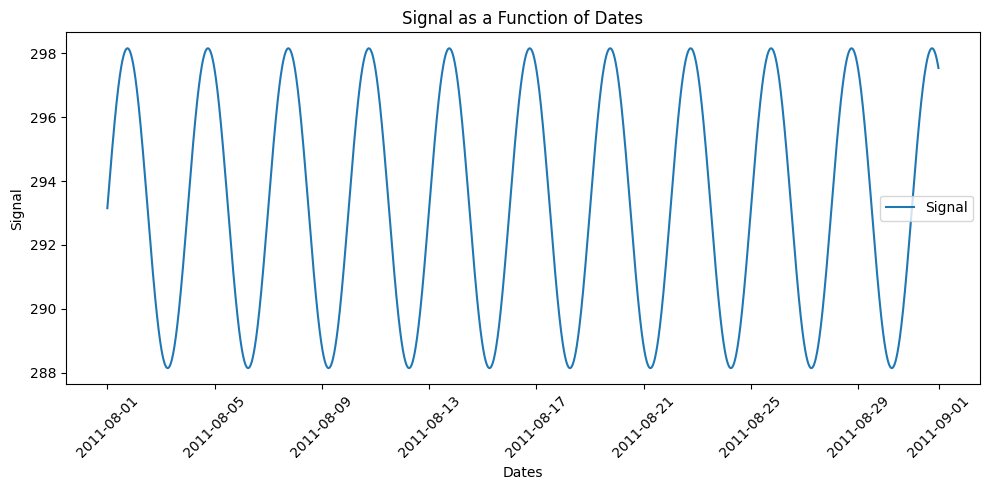

Notebook exécuté avec succès.


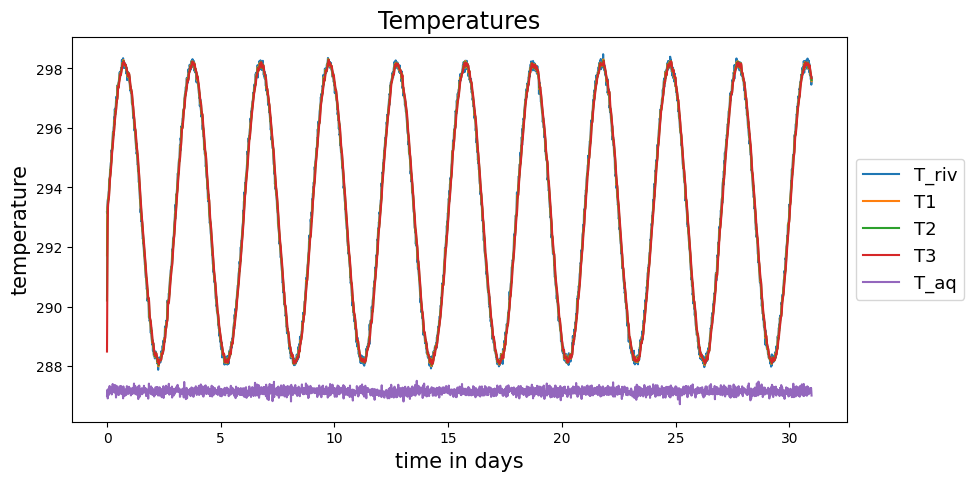

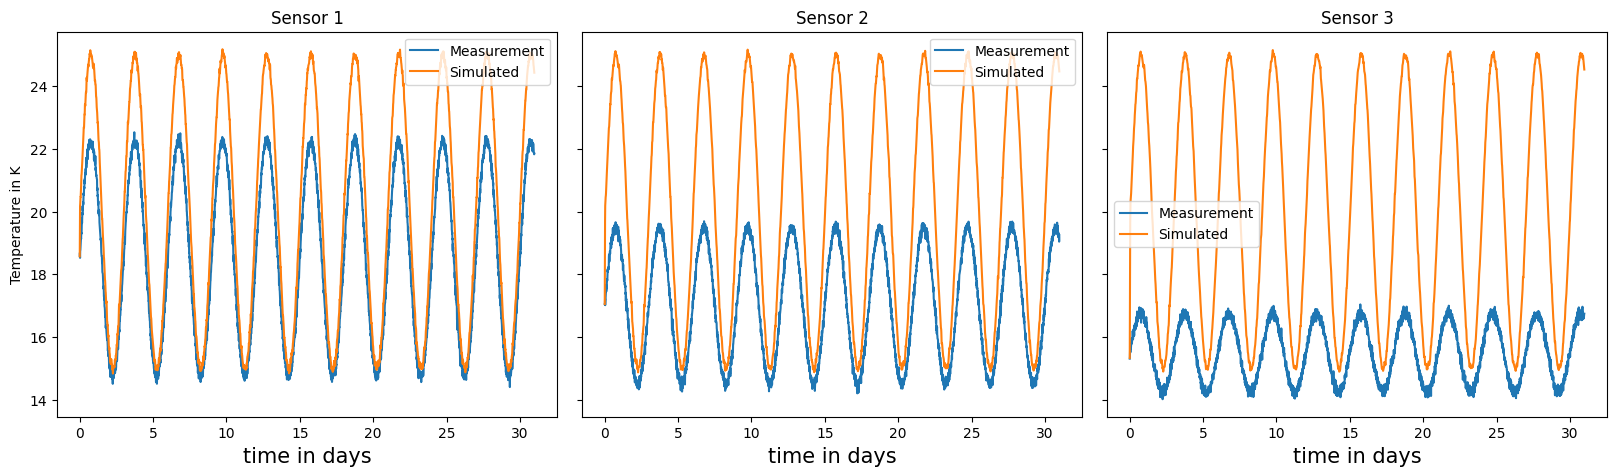

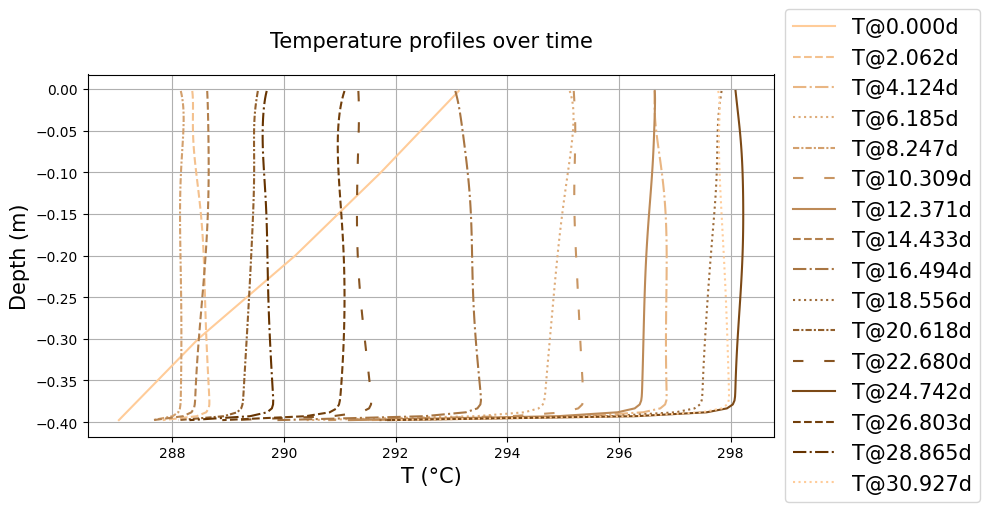

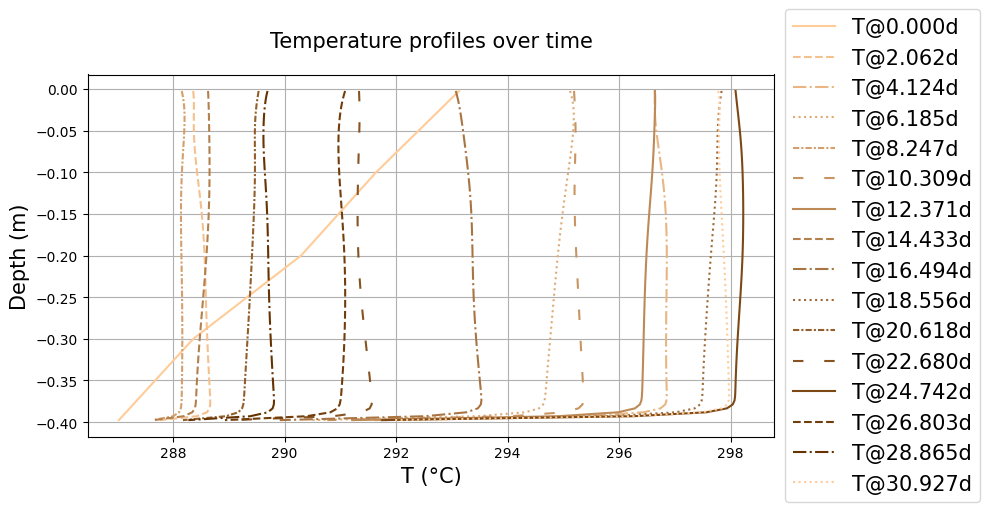

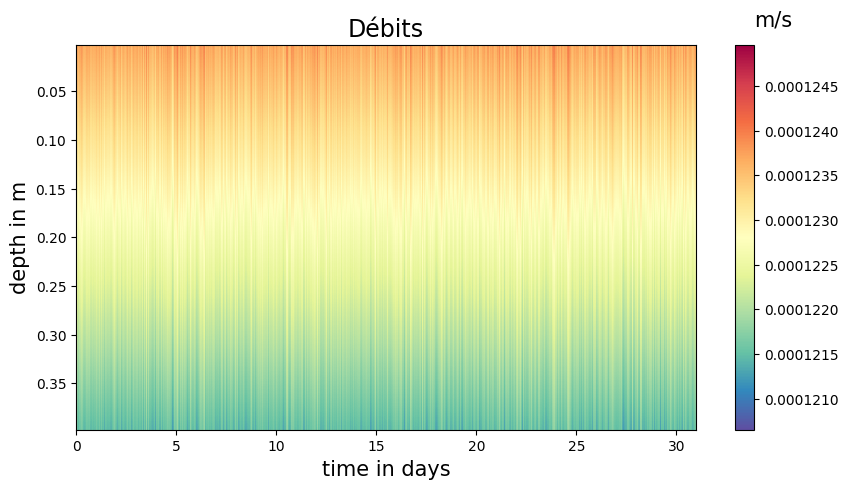

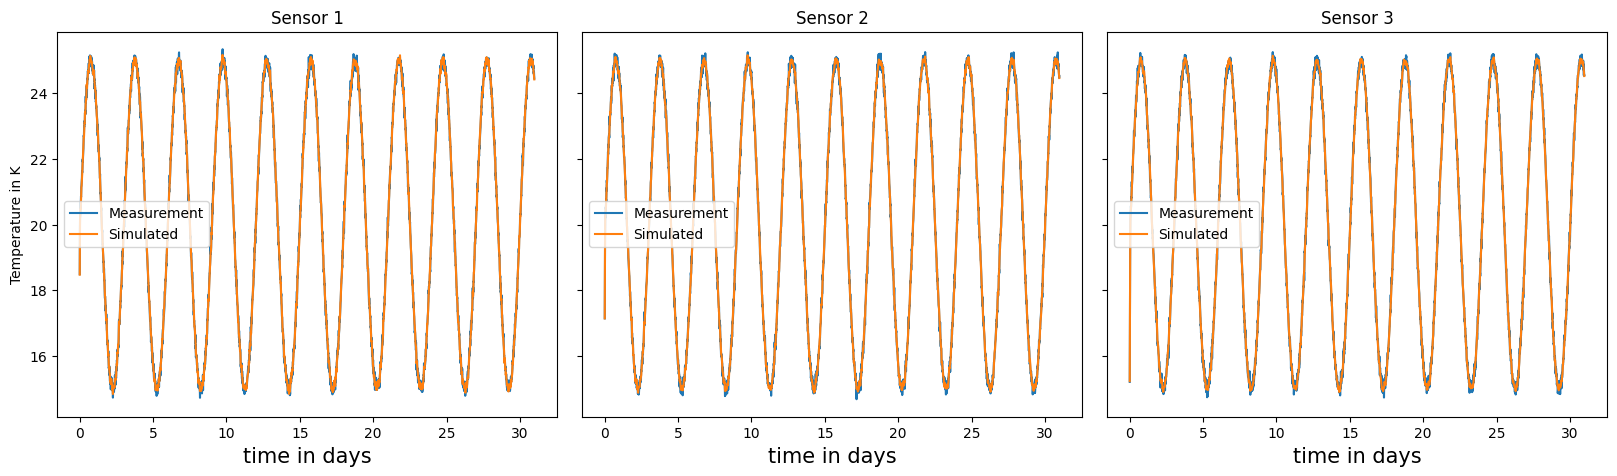

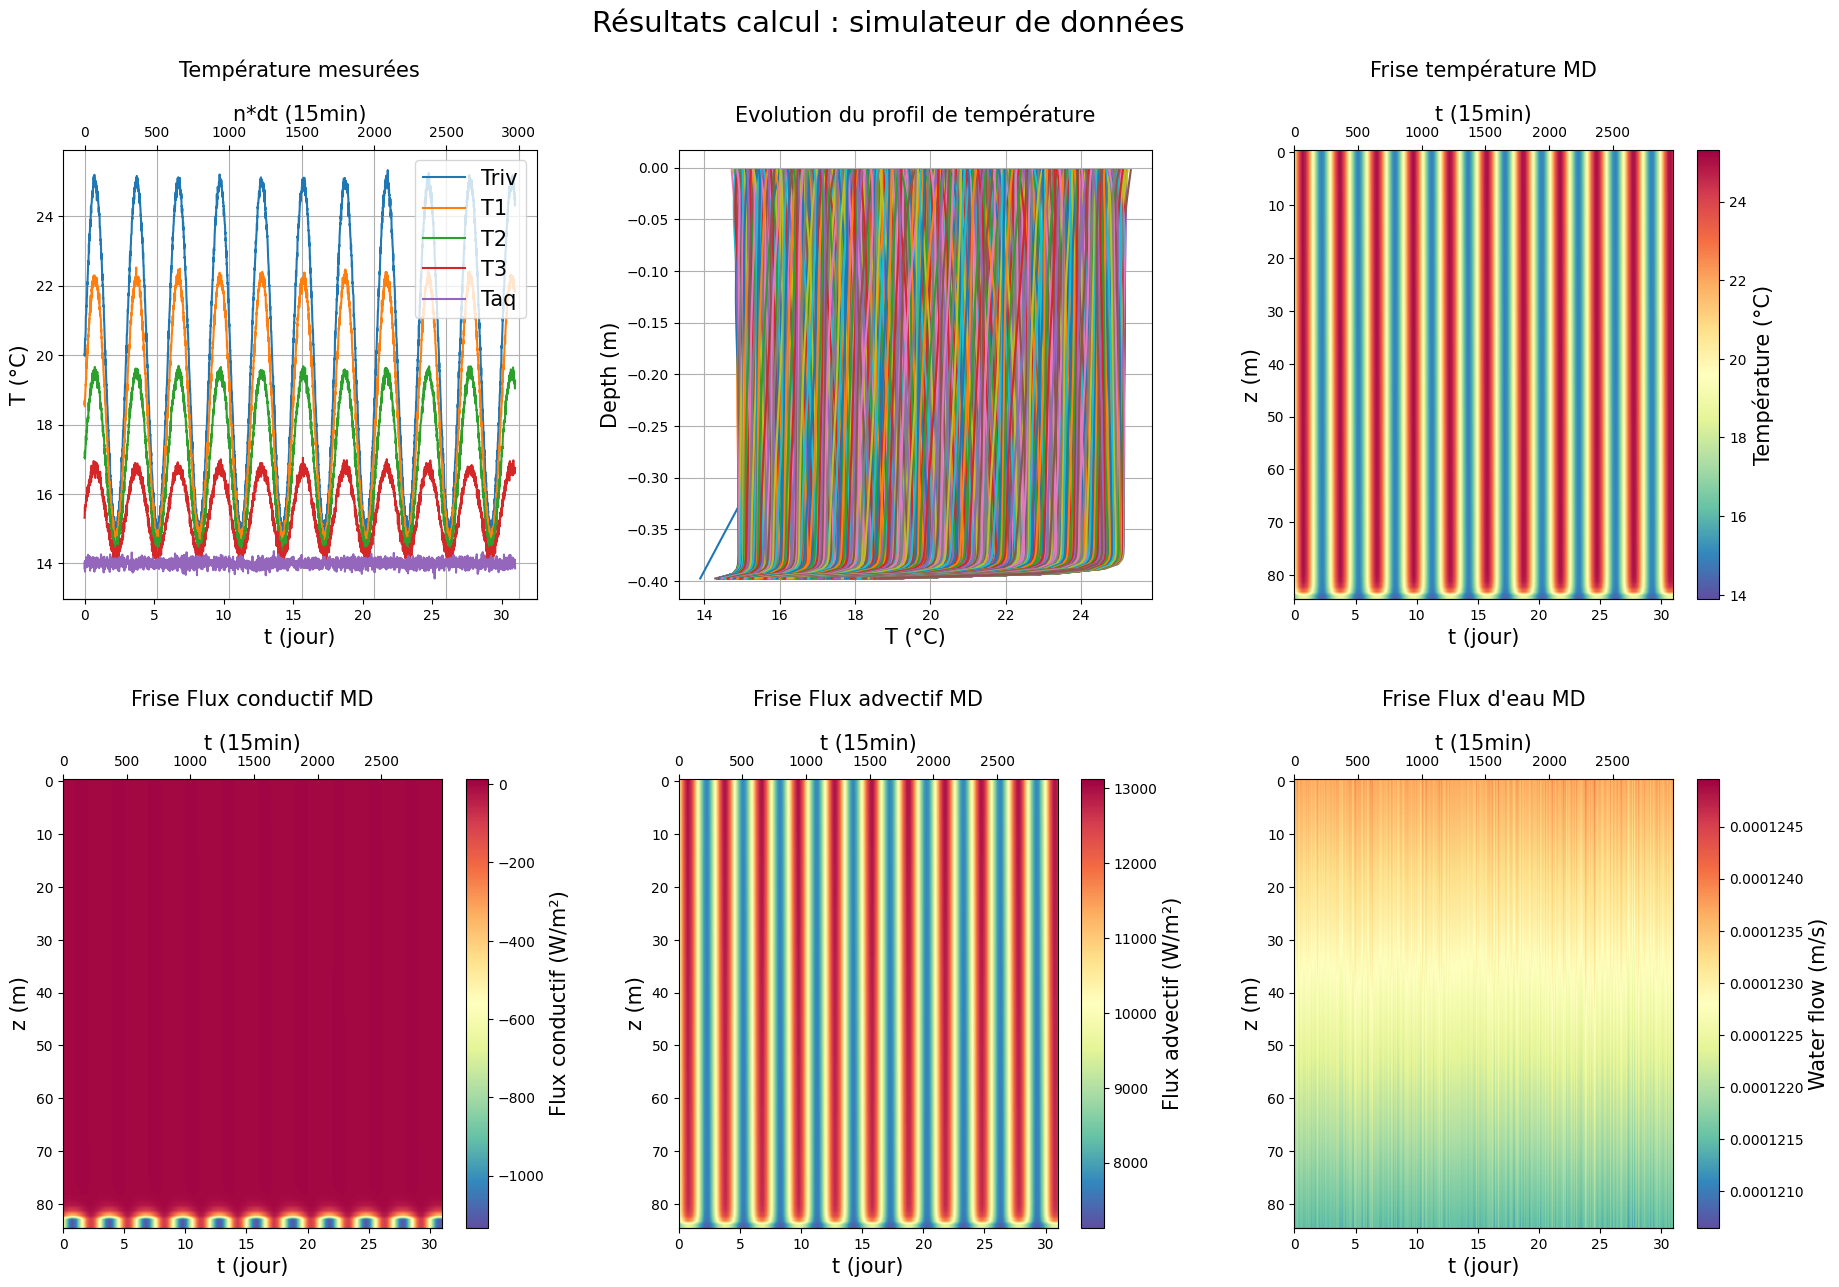

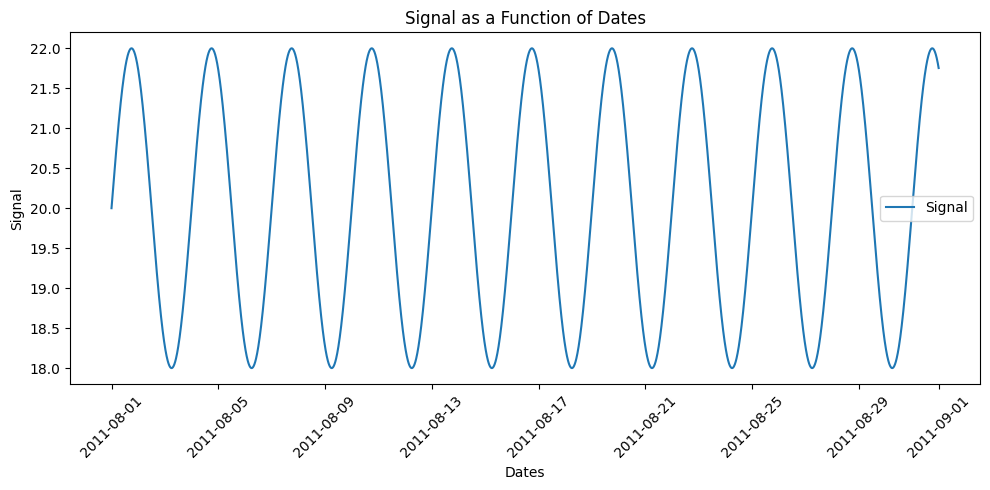

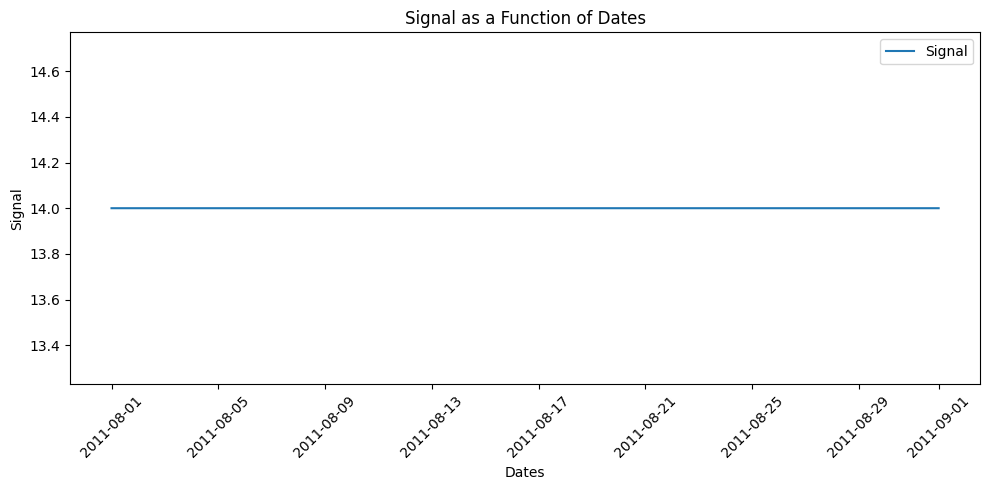

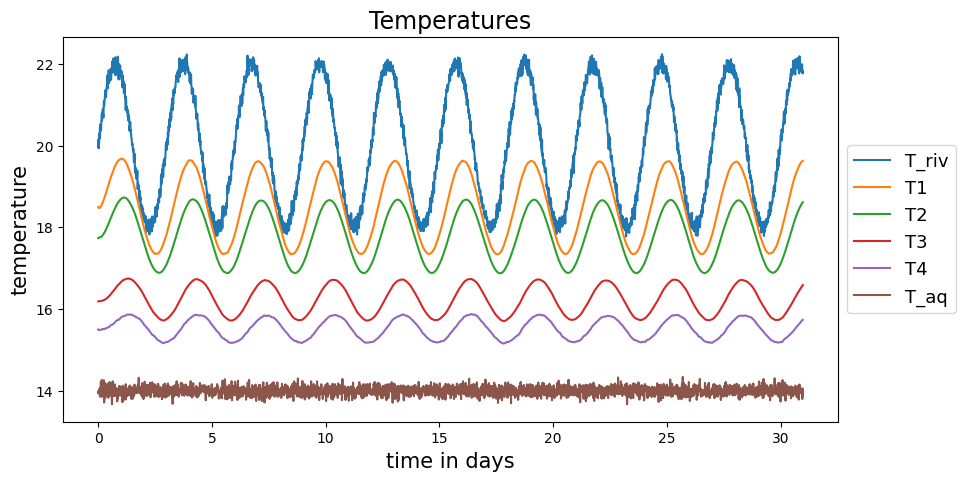

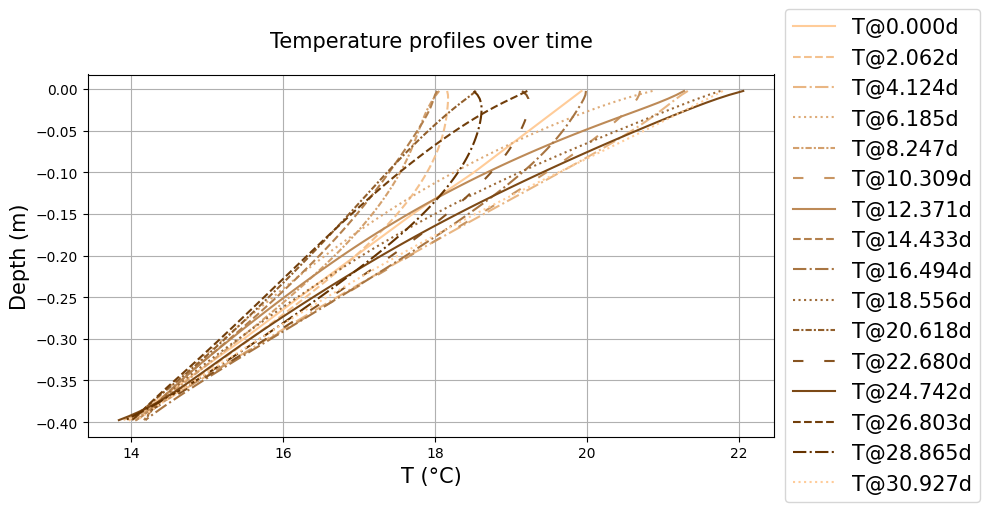

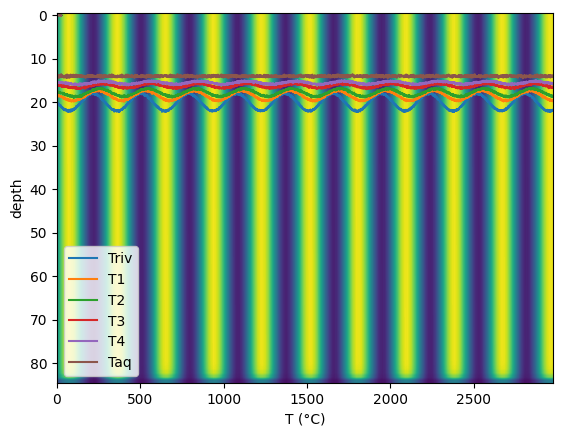

In [92]:
import nbformat
from nbconvert.preprocessors import ExecutePreprocessor
from contextlib import redirect_stdout, redirect_stderr
from io import StringIO

path_demoGenData = "research/synthetic_cases_generator/demo_genData.ipynb"

# Fonction pour exécuter un notebook
def run_notebook(notebook_path):
    # Charger le notebook
    with open(notebook_path) as f:
        notebook = nbformat.read(f, as_version=4)

    # Configurer l'ExecutePreprocessor pour exécuter toutes les cellules
    ep = ExecutePreprocessor(timeout=600, kernel_name='python3')

    # Exécuter le notebook
    try:
        ep.preprocess(notebook, {'metadata': {'path': './'}})
        print("Notebook exécuté avec succès.")
    except Exception as e:
        print(f"Erreur lors de l'exécution du notebook : {e}")

# Fonction pour importer les valeurs des cellules de code d'un notebook dans le contexte global
def import_notebook_values(notebook_path):
         # Load the notebook
    with open(notebook_path) as f:
        notebook = nbformat.read(f, as_version=4)

    # Create a dictionary to hold the globals
    notebook_globals = {}

    # Suppress standard output and error using `redirect_stdout` and `redirect_stderr`
    with StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
        try:
            # Execute each code cell
            for cell in notebook.cells:
                if cell.cell_type == 'code':
                    exec(cell.source, notebook_globals)
        except Exception as e:
            print(f"Error while executing notebook: {e}")

run_notebook(path_demoGenData)
import_notebook_values(path_demoGenData);

On extrait ensuite et traite les données générées par le notebook, de la même façon qu'elles sont traitées dans ``demo_Pyheatmy.ipynb``.

In [77]:
# define the folder path
folder = col._dir_print + '/VirtualPoint'

# read the data
capteur_riviere = pd.read_csv(folder + "/VirtualPoint_P_measures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv(folder + "/VirtualPoint_T_measures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("./configuration/pressure_sensors/P508.csv")

On définit une fonction pour convertir les dates des dataframe, cela peut éviter certains problèmes.

In [78]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

On définit les objets ``dH_measures`` et ``T_measures``, nécessaires à la création d'un objet ``Column``, qui réalisera les calculs :
- ``dH_measures`` contient les dates des mesures, les mesures de différence de charge, et les températures de la rivière.
- ``T_measures`` contient les dates des mesures, et les températures mesurées par les 4 capteurs de la tige.

In [79]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + ZERO_CELSIUS
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + ZERO_CELSIUS
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + ZERO_CELSIUS
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + ZERO_CELSIUS
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + ZERO_CELSIUS

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

print(f"dH : {dH_measures}")
print(f"Tshaft : {T_measures}")


dH : [(Timestamp('2011-08-01 00:00:00'), (0.7800327917702282, 566.3996999999999)), (Timestamp('2011-08-01 00:15:00'), (0.7806617846898622, 566.4132)), (Timestamp('2011-08-01 00:30:00'), (0.7814840285949696, 566.5506)), (Timestamp('2011-08-01 00:45:00'), (0.7809945673660421, 566.6077)), (Timestamp('2011-08-01 01:00:00'), (0.7812887767821429, 566.5604)), (Timestamp('2011-08-01 01:15:00'), (0.780939970803319, 566.8249)), (Timestamp('2011-08-01 01:30:00'), (0.7825415085863542, 566.9214)), (Timestamp('2011-08-01 01:45:00'), (0.7826544325963507, 566.9656)), (Timestamp('2011-08-01 02:00:00'), (0.7822649237091408, 567.3254)), (Timestamp('2011-08-01 02:15:00'), (0.7826195472805034, 567.2701999999999)), (Timestamp('2011-08-01 02:30:00'), (0.7815932550880517, 567.3374)), (Timestamp('2011-08-01 02:45:00'), (0.7824314811332689, 567.5585)), (Timestamp('2011-08-01 03:00:00'), (0.7828222012382949, 567.6748)), (Timestamp('2011-08-01 03:15:00'), (0.7823597937770728, 567.6909)), (Timestamp('2011-08-01 03

On définit maintenant l'objet ``Column`` à partir d'un dictionnaire.

In [80]:
Zbottom = 0.4

col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, Zbottom],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

## Inversion des données générées

On va maintenant inverser les données générées pour obtenir les différentes caractéristiques.

In [94]:
priors = {
    "moinslog10IntrinK": ((3+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.01, .25), .01),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
    "q": ((1e-9, 1e-5), 1e-10),
}

all_priors = [
    ['Couche 1', Zbottom, priors],
]
col.compute_mcmc(
    nb_iter = NBITER,
    all_priors = all_priors,
    verbose=True
)

bestLayers = col.get_best_layers()

{'moinslog10IntrinK': ((10, 16), 0.01), 'n': ((0.01, 0.25), 0.01), 'lambda_s': ((1, 10), 0.1), 'rhos_cs': ((1000000.0, 10000000.0), 100000.0), 'q': ((1e-09, 1e-05), 1e-10)}
5
5
5
5
5
5
5
5
5
5
5
5
--- Compute DREAM MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 10 et 16, Prior sur une valeure qui évolue entre 0.01 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0, Prior sur une valeure qui évolue entre 1e-09 et 1e-05]
Number of cells : 85
Number of iterations : 10
Number of chains : 10
--------------------
Initialisation - Utilisation de la mémoire (en Mo) : 150.781952
--- Begin Burn in phase ---


Burn in phase: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 104.972288
DREAM MCMC Computation: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]
Fin itérations MCMC, avant le calcul des quantiles - Utilisation de la mémoire (en Mo) : 106.921984
Quantiles computed


Text(0, 0.5, 'Itérations')

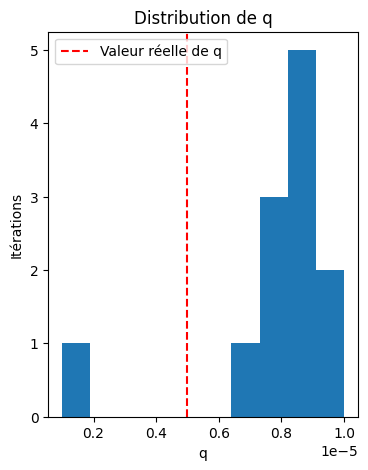

In [82]:
import matplotlib.pyplot as plt

q_samples = col.get_all_params()[0][:, 4]


fig, ax = plt.subplots()
fig.set_size_inches(4, 5)
ax.hist(q_samples, bins=10, range = (1e-6, 1e-5)) 
ax.axvline(x=q, color='r', linestyle='--', label='Valeur réelle de q')
ax.legend()
ax.set_title("Distribution de q")
ax.set_xlabel("q")
ax.set_ylabel("Itérations")

## Comparaison des paramètres réels et de ceux inversés

On peut à présent comparer les données inversées et celles orignales.

In [83]:
print('Paramètres réels :', 'moinslog10IntrinK =', moinslog10IntrinK, ', n =', n, ', lambda_s =', lambda_s, ', rhos_cs =',rhos_cs, ', q =',q) # valeurs importées du notebook demo_genData.ipynb
print('Paramètres inversés :', str(bestLayers[0])[37:-1]) # valeurs calculées par le modèle

Paramètres réels : moinslog10IntrinK = 11 , n = 0.1 , lambda_s = 2 , rhos_cs = 4000000.0 , q = 5e-06
Paramètres inversés : moinslog10IntrinK=12.058383, n=0.04397504, lambda_s=1.1262243, rhos_cs=6208502.0, q=1.4692405e-06
